<H1>Relationship between IL and price change in a stableswap pool</H1>


In [8]:
import sys
import os
import glob
import random
import copy
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.50},
    'USDB': {'usd price': 1, 'weight': 0.50}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=1000,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={'USDA': 5000, 'USDB': 5000},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)


In [53]:
steps = 201
# price_min = 0.2
# price_max = 5
trade_size_min, trade_size_max = -1000000, 1000000
step_factor = (trade_size_max / trade_size_min) ** (1 / (steps - 1))
trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
# [-trade_size_min * step_factor ** i for i in range(steps)][::-1] + [trade_size_min * step_factor ** i for i in range(steps)]
events = []

initial_holdings = copy.deepcopy(initial_state.agents['LP'].holdings)
initial_trader_holdings = copy.deepcopy(initial_state.agents['Trader'].holdings)
first_state = initial_state.copy()

for trade_size in trade_sizes:

    events.append(
        run.run(initial_state, time_steps=1, silent=True)[-1].execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=max(abs(trade_size), 0),
        )
    )

usda_prices = [
    1 / event.pools['stableswap'].spot_price
    for event in events
]

usdb_prices = [
    event.pools['stableswap'].spot_price
    for event in events
]

d_list = []
for event in events:
    ss = event.pools['stableswap']
    d_list.append(ss.calculate_d())

for event in events:
    StableSwapPoolState.execute_remove_uniform(
        state=event.pools['stableswap'],
        agent=event.agents['LP'],
        shares_removed=event.agents['LP'].holdings['stableswap']
    )

asset_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=initial_holdings)
    for i, event in enumerate(events)
]

asset_value_2 = [
    value_assets(prices={'USDB': usdb_prices[i], 'USDA': 1}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value_2 = [
    value_assets(prices={'USDB': usdb_prices[i], 'USDA': 1}, assets=initial_holdings)
    for i, event in enumerate(events)
]

# agent_funds = [
#     event.cash_out(event.agents['LP'])
#     for i, event in enumerate(events)
# ]

impermanent_loss = [
    asset_value[i] / deposit_value[i] - 1
    for i, event in enumerate(events)
]

impermanent_loss_2 = [
    asset_value_2[i] / deposit_value_2[i] - 1
    for i, event in enumerate(events)
]

agent_value = [
    value_assets(
        prices={
            'USDA': usda_prices[i]
        }, 
        assets=initial_holdings
    ) - 1
    for i in range(len(events))
]

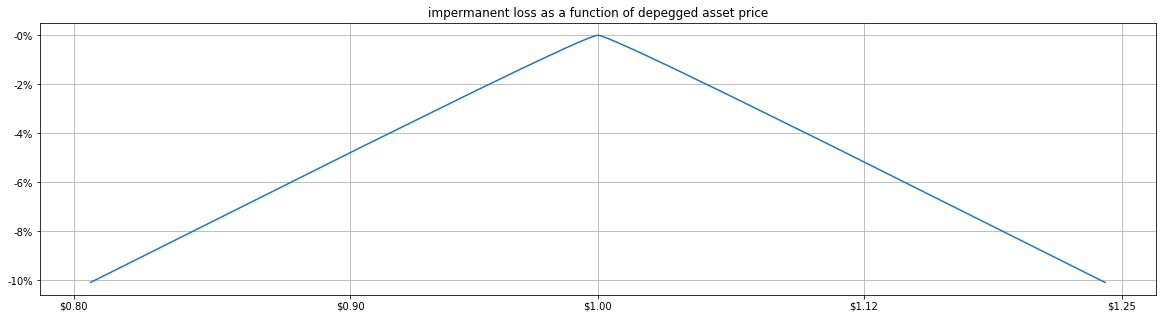

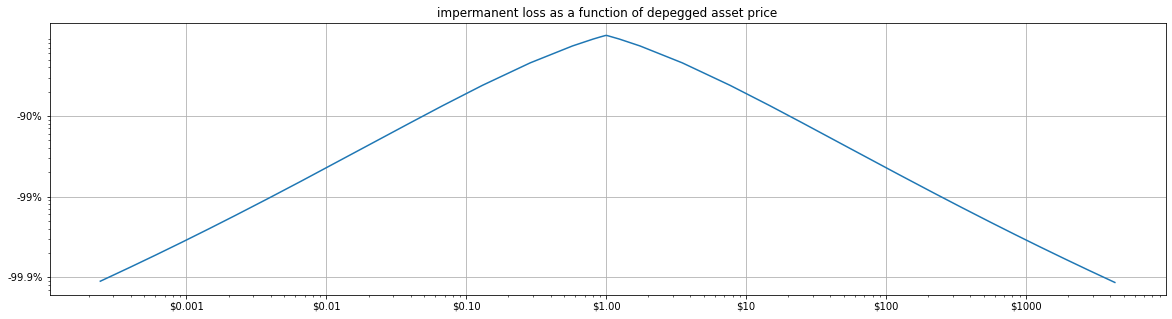

In [66]:
# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.8, 0.9, 1, 1.12, 1.25],
    ['$0.80', '$0.90', '$1.00', '$1.12', '$1.25']
)
plt.yticks(
    [-0.02 * i for i in range(6)],
    [f'-{2 * i}%' for i in range(6)]
)
center = usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - 1))[0])
start_range = center - round(len(usda_prices) / 4)
end_range = center + round(len(usda_prices) / 4)
plt.plot(usda_prices[start_range: end_range], impermanent_loss[start_range: end_range])

# zoom out
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price')
plt.xscale('log')
plt.grid()
plt.yscale('log')
plt.yticks(
    [0.1, 0.01, 0.001],
    ['-90%', '-99%', '-99.9%']
)
plt.xticks(
    [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    ['$0.001', '$0.01', '$0.10', '$1.00', '$10', '$100', '$1000']
)
plt.plot(usda_prices,  [loss + 1 for loss in impermanent_loss])

